# **Product Clustering with P2V and Agglomerative Clustering**

In [2]:
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.cluster import AgglomerativeClustering

In [3]:
DATA_PATH = '../data/'
EXPORT_PATH = '../export/'

In [4]:
baskets = pd.read_parquet(DATA_PATH + 'baskets.parquet')
baskets['basket'] = baskets.groupby(['week', 'shopper']).ngroup()

## **P2V DataLoader**

In [5]:
class P2VDataLoader:
    def __init__(
        self,
        baskets: pd.DataFrame,
        basket_var = 'basket',
        product_var = 'product'
    ):
        self.basket_var = basket_var
        self.product_var = product_var
        self.load(baskets)

    def basket_to_list(self, basket):
        return basket.astype(str).tolist()
    
    def baskets_to_list(self, baskets):
        baskets_grouped = baskets.groupby(self.basket_var)[self.product_var]
        baskets_list = baskets_grouped.agg(self.basket_to_list).tolist()
        return baskets_list
    
    # ToDo: move this functionality to helper class
    def load(self, baskets):
        try:
            with open(EXPORT_PATH + 'baskets_list', 'rb') as bl:
                print('Reading baskets_list from pickle...')
                self.output = pickle.load(bl)
        except IOError:
            print(f'No pickle found in {DATA_PATH}. Computing baskets_list. This can take 15 minutes...')
            self.output = self.baskets_to_list(baskets)
            with open(EXPORT_PATH + 'baskets_list', 'wb') as bl:
                pickle.dump(self.output, bl)
        finally:
              print("Successfully read baskets_list into memory.")

In [6]:
#---------------------- Load data for P2V Model ----------------------#
p2v_data_loader = P2VDataLoader(baskets)
p2v_input = p2v_data_loader.output

Reading baskets_list from pickle...
Successfully read baskets_list into memory.


## **P2V Model**

In [7]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

class P2V:
    def __init__(self, baskets, embedding_dimensions):
        w2v_config = {
            'sentences': baskets,
            'min_count': 2,
            'window': len(max(baskets, key=len)),
            'size': embedding_dimensions,
            'workers': 3,
            'sg': 1
        }
        self.init(w2v_config)

    def get_embeddings(self):
        return self.model.wv[self.model.wv.vocab]
             
    def most_similar_products(self, product):
        return self.model.wv.most_similar(product)
        
    def tsne_plot(self, n_components=2, perplexity=4, random_state=0, figsize=(15,15)):
        result = TSNE(
            n_components = n_components, 
            perplexity = perplexity, 
            random_state = random_state
        ).fit_transform(self.get_embeddings())
        plt.figure(figsize=figsize)
        plt.scatter(result[:, 0], result[:, 1])
        products = list(self.model.wv.vocab)
        for i, product in enumerate(products):
            plt.annotate(product, xy=(result[i, 0], result[i, 1]))
        plt.show()

    def init(self, w2v_config):
        try:
            self.model = Word2Vec.load("../data/p2v.model")
        except IOError:
            self.model = Word2Vec(**w2v_config)
            self.model.save("p2v.model")

In [8]:
p2v_config = {
    'baskets': p2v_input,
    'embedding_dimensions': 100
}

p2v = P2V(**p2v_config)

In [18]:
p2v.most_similar_products('75')

[('74', 0.5859091877937317),
 ('76', 0.5728287696838379),
 ('78', 0.5715720653533936),
 ('79', 0.5675590634346008),
 ('77', 0.5590436458587646),
 ('72', 0.5488961935043335),
 ('73', 0.4891132414340973),
 ('71', 0.4239960014820099),
 ('239', 0.3955577611923218),
 ('70', 0.3585425615310669)]

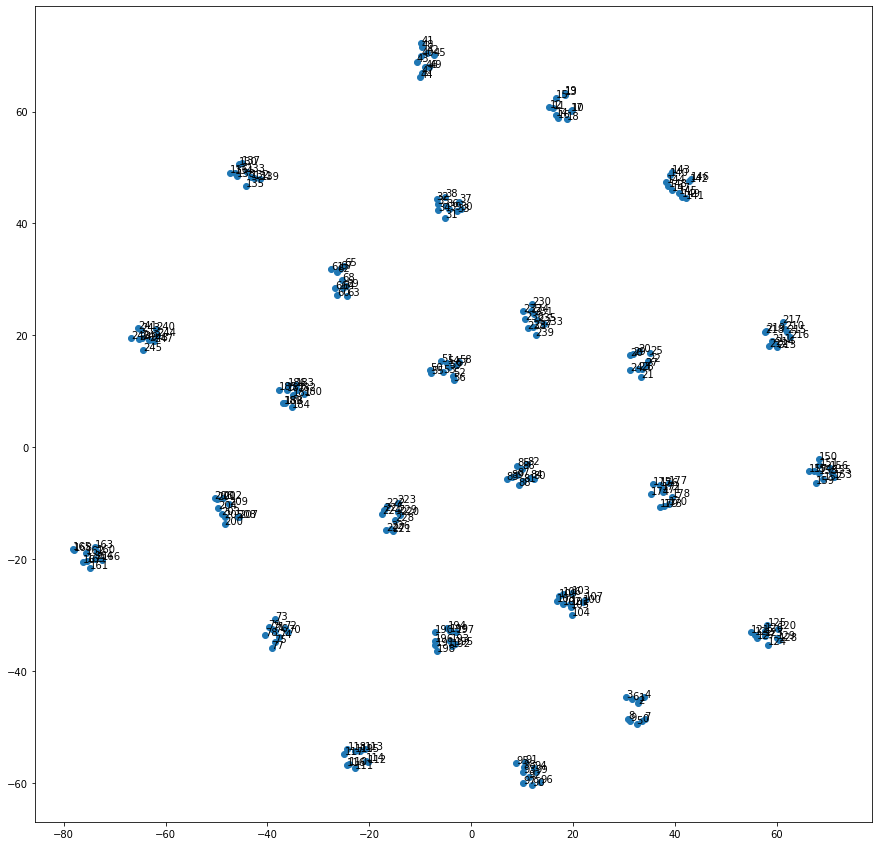

In [29]:
p2v.tsne_plot(figsize=(15,15))

## **Co-occurrence Printer**

In [173]:
class Co_occurence_printer:
    def __init__(self, data, group_var="basket", member_var="product"):
        self.data = data
        self.group_var = group_var
        self.member_var = member_var
        self.member_1 = member_var + '_1'
        self.member_2 = member_var + '_2'
        self.value = 'co-occurrence'
        self.table = self.compute_table()

    def co_occurrences_sparse(self):
        x = self.data
        group = self.group_var
        member = self.member_var
        
        row = x[group].values
        col = x[member].values
        dim = (x[group].max()+1, x[member].max()+1)

        group_member_table = scipy.sparse.csr_matrix(
            (np.ones(len(row), dtype=int), (row, col)),
            shape=dim
        )
        co_occurrences_sparse = group_member_table.T.dot(group_member_table).tocoo()
        co_occurrences_df = pd.DataFrame({
            self.member_1: co_occurrences_sparse.row,
            self.member_2: co_occurrences_sparse.col,
            self.value: co_occurrences_sparse.data,
        })
        return co_occurrences_df
        
    def compute_table(self):
        co_occurrences_df = self.co_occurrences_sparse()
        pivot_table = co_occurrences_df.pivot(
            index   = self.member_1, 
            columns = self.member_2, 
            values  = self.value
        ).fillna(0)
        return pivot_table

    def plot_heatmap(self, figsize=(10,10)):
        '''
            we clip the large self-co-occurences (diagonal values)
            to the max non-self coocuerence (non-diagonal value)

        '''
        table = self.table
        np.fill_diagonal(table.values, 0)
        max_non_diagonal = table.mean().mean()
        np.fill_diagonal(table.values, max_non_diagonal)
        dist_table = 1 - table
        # add figsize option
        plt.matshow(dist_table, cmap=plt.cm.Blues)
        plt.title(f"{self.member_var}-{self.value} heatmap")
        plt.xlabel(self.member_1)
        plt.ylabel(self.member_2)
        plt.show() 

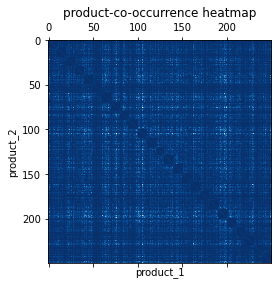

product_2,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
product_1,,,,,,,,,,,,,,,,,,,,,
0,8134.738016,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,4932.0,574.0,11041.0,2026.0,763.0,1362.000000,4780.000000,470.000000,4828.000000,18119.000000
1,0.000000,8134.738016,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,16124.0,2228.0,12742.0,7224.0,6068.0,7541.000000,12030.000000,2107.000000,30629.000000,17982.000000
2,0.000000,0.000000,8134.738016,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,946.0,2356.0,11997.0,950.0,999.0,4089.000000,6190.000000,2170.000000,15655.000000,4817.000000
3,0.000000,0.000000,0.000000,8134.738016,0.000000,0.0,0.0,0.0,0.0,0.0,...,1081.0,354.0,3406.0,1172.0,569.0,976.000000,2155.000000,250.000000,3421.000000,12281.000000
4,0.000000,0.000000,0.000000,0.000000,8134.738016,0.0,0.0,0.0,0.0,0.0,...,3372.0,4143.0,5252.0,6948.0,3067.0,3387.000000,4136.000000,290.000000,2862.000000,23128.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1362.000000,7541.000000,4089.000000,976.000000,3387.000000,459.0,2909.0,3529.0,4082.0,4958.0,...,0.0,0.0,0.0,0.0,0.0,8134.738016,0.000000,0.000000,0.000000,0.000000
246,4780.000000,12030.000000,6190.000000,2155.000000,4136.000000,12211.0,4874.0,1002.0,4063.0,5273.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,8134.738016,0.000000,0.000000,0.000000
247,470.000000,2107.000000,2170.000000,250.000000,290.000000,929.0,1064.0,2680.0,2432.0,1487.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8134.738016,0.000000,0.000000


In [174]:
product_co_occurence = Co_occurence_printer(baskets)
product_co_occurence.plot_heatmap()
product_co_occurence.table

### Create Product Clusters (categories)

In [177]:
cut_bins = list(range(0, 251, 10))
cut_labels = list(range(0, 25))
baskets['product_cat'] = pd.cut(baskets['product'], bins=cut_bins, labels=cut_labels, right=False)

### Create Category Clusters (complementary categories like chips and coca-cola)

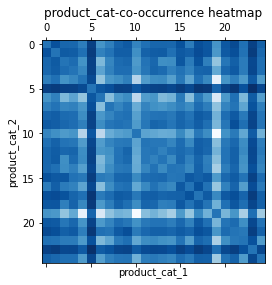

product_cat_2,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
product_cat_1,,,,,,,,,,,,,,,,,,,,,
0,813473,483201,679819,693296,898182,332533,1107574,916306,648558,573262,...,497846,889546,461271,535876,1114943,546179,428611,777330,342434,629797
1,483201,813473,578338,595444,775933,294662,938092,807280,610162,606929,...,560709,613555,450930,533113,1153157,565948,465920,796035,309227,700367
2,679819,578338,813473,734031,1088993,342771,1486465,970499,728605,693178,...,544805,875316,503817,917496,1617375,828036,621952,873589,413785,764884
3,693296,595444,734031,813473,984807,357629,1267477,933977,747256,746141,...,795916,944202,675812,652353,1327812,691445,571066,875548,399541,765466
4,898182,775933,1088993,984807,813473,427959,1620520,1135116,1041711,914633,...,851474,1276136,774164,986221,2400646,1102314,908108,1160453,570402,1166422
5,332533,294662,342771,357629,427959,813473,539069,465358,353006,360198,...,315668,405851,254485,280752,661487,361144,257818,488365,179530,397372
6,1107574,938092,1486465,1267477,1620520,539069,813473,1551544,1142611,1038447,...,869732,1552628,864129,1156929,2223366,1156720,772075,1490070,591233,1216547
7,916306,807280,970499,933977,1135116,465358,1551544,813473,958200,822145,...,918982,1039116,737175,894936,1600561,962245,807649,1291285,503686,917667
8,648558,610162,728605,747256,1041711,353006,1142611,958200,813473,770150,...,680560,806018,577482,641621,1418860,745566,568113,857212,389864,818533


In [178]:
category_co_occurence = Co_occurence_printer(baskets, group_var="basket", member_var="product_cat")
category_co_occurence.plot_heatmap()
category_co_occurence.table

In [8]:
cat_co_occurrences_df = co_occurrences_sparse(
    x=baskets,
    variable_basket="order_id",
    variable_product="product_cat"
)
cat_co_occurrences_df = cat_co_occurrences_df.sort_values(["product_1", "product_2"]).reset_index()
cat_co_occurrences_df = cat_co_occurrences_df.rename(columns={"product_1": "cat_1", "product_2": "cat_2"})
cat_pivot_df = cat_co_occurrences_df.pivot(
    index="cat_1", 
    columns="cat_2", 
    values="co-occurrence"
)
cat_pivot_df.head()

NameError: name 'co_occurrences_sparse' is not defined

In [ ]:
plt.matshow(cat_pivot_df, cmap=plt.cm.Blues)
plt.title("Co-Clustering of Category Purchases")
plt.show()

In [ ]:
# rescale high diagonal values to mean
def rescale_diagonal(_df):
    df = _df.copy()
    np.fill_diagonal(df.values, 0)
    df_max = df.mean().mean()
    np.fill_diagonal(df.values, df_max)
    return df

cat_dist = rescale_diagonal(cat_pivot_df)

plt.matshow(cat_dist, cmap=plt.cm.Blues)
plt.title("Co-Clustering of Category Purchases")
plt.show()

In [ ]:
### Agglomerative Category Clustering

In [179]:
cat_dist = category_co_occurence.table

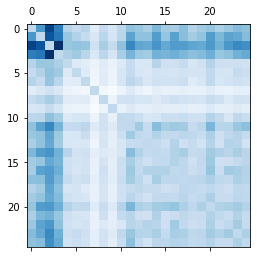

In [180]:
df_agg = cat_dist.to_numpy()
# ward minimizes the variance of the clusters being merged
model = AgglomerativeClustering(linkage='ward', n_clusters=3).fit(df_agg)
new_order = np.argsort(model.labels_)
ordered_dist = df_agg[new_order]
ordered_dist = ordered_dist[:,new_order]
plt.matshow(ordered_dist, cmap=plt.cm.Blues)

In [181]:
cluster_labels = pd.DataFrame({"cluster": model.labels_})
baskets = baskets.merge(cluster_labels, left_on="product_cat", right_index=True)

In [182]:
model.labels_

array([1, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1,
       2, 1, 2])

In [183]:
cat_cluster_labels = [1, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2] 

In [185]:
cluster_labels = pd.DataFrame({"cat_cluster": model.labels_})
cluster_labels

,cat_cluster
0,1
1,1
2,2
3,2
4,0
5,1
6,0
7,2
8,2
9,2


In [ ]:
baskets = baskets.merge(cluster_labels, left_on="product_cat", right_index=True)

In [13]:
baskets

,week,shopper,product,price,basket,product_cat,cluster
0,0,0,71,629,0,7,2
32,0,4,76,582,4,7,2
50,0,7,79,736,7,7,2
60,0,8,74,584,8,7,2
71,0,9,76,582,9,7,2
...,...,...,...,...,...,...,...
68841153,89,99939,54,773,8998578,5,1
68841193,89,99945,57,716,8998584,5,1
68841298,89,99961,56,761,8998600,5,1
68841312,89,99963,52,607,8998602,5,1


In [14]:
cluster_labels

,cluster
0,1
1,1
2,2
3,2
4,0
5,1
6,0
7,2
8,2
9,2


In [12]:
model.labels_

array([1, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1,
       2, 1, 2])

In [32]:
model.labels_

array([0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 2, 0])